# **COMP 478 Project**
##Denoise algorithm comparison
####Diana Zitting-Rioux ID: 40017023

In [96]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageFilter
from skimage.util import random_noise
from skimage.measure import compare_ssim
from skimage.restoration import denoise_nl_means, estimate_sigma
from math import log10, sqrt
from statistics import mean
import cv2
import glob
from google.colab.patches import cv2_imshow
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
os.chdir("/content/drive/My Drive/")

Images from Stanford dogs Chihuahua dataset




<class 'numpy.ndarray'>


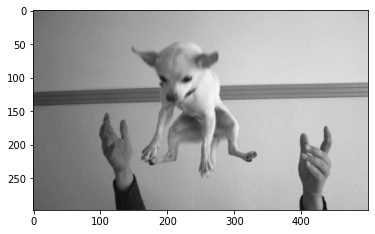

In [ ]:
#Reading original test image
img_original  = cv2.imread('./images/Images/n02085620-Chihuahua/n02085620_275.jpg', cv2.IMREAD_GRAYSCALE) 


images = []
path = './images/Images/n02085620-Chihuahua/'
for filename in glob.glob('./images/Images/n02085620-Chihuahua/*.jpg'):
  images.append(cv2.imread(filename, cv2.IMREAD_GRAYSCALE))

#Checking that images are read
print(type(images[0]))
plt.imshow(images[0],cmap = 'gray')


In [ ]:
#Creating Gaussian noise image
img_gauss_noise =  random_noise(img_original, mode='gaussian',var =0.1)
#Creating Salt and Pepper noise image
img_saltpepper_noise = random_noise(img_original, mode = 's&p', amount=0.05)

In [ ]:
# Mean Square Error for measuring denoise performance
def mse(input1, input2):
  mse_error = np.mean((input1 - input2)**2)
  return mse_error

In [ ]:
def psnr(input1, input2):
    #Peak Signal-to-Noise Ratio for measuring denoise performance
    mse_error = mse(input1, input2)
    if(mse_error == 0):
      return 100
    psnr_error = 20 * log10(255.0/sqrt(mse_error))
    return psnr_error

In [ ]:
#Image comparison function
def compare(img1, img2, img3):
  mse_error = mse(img1, img3)
  # Computing Structural Similarity Index
  #ssim_error = compare_ssim(img1, img3)
  psnr_error = psnr(img1, img3)
  images = [img1, img2, img3]
  image_name = ['Original', 'Noisy', 'Filtered']
  for i in range(3):
    plt.subplot(1,3,i +1 ),plt.imshow(images[i],cmap = 'gray')
    plt.suptitle("MSE: %.2f, SSIM: %.2f" % (mse_error, psnr_error))
    plt.title(image_name[i]), plt.axis('off')    
    plt.tight_layout(.1 ) 
  plt.show() 
  return mse_error, psnr_error


In [ ]:
def compare_data(img1, img2, img3):
  mse_error = mse(img1, img3)
  # Computing Structural Similarity Index
  #ssim_error = compare_ssim(img1, img3)
  psnr_error = psnr(img1, img3)
  return mse_error, psnr_error

Gauss Noise for all images

In [ ]:
#Create noise for images in the folder
def gauss_noise():
  gaussn_list = []
  for img in images:
    img_gauss_noise =  random_noise(img, mode='gaussian',var =0.05)
    gaussn_list.append(img_gauss_noise)
  return gaussn_list


Impulse Noise for all images

In [127]:
def impulse_noise():
  impulse_list = []
  for img in images:
    img_impulse=random_noise(img, mode = 's&p', amount=0.05)
    impulse_list.append(img_impulse)
  return impulse_list

In [ ]:
#def compare_mse(original_img, img_list):


Mean Filter

In [ ]:
def mean_filter(img):
  output = cv2.boxFilter(img, -1,(3,3))
  return output

Median Filter

In [ ]:
def median_filter(img):
  img = img.astype('float32')
  output = cv2.medianBlur(img,5)
  return output

Bilateral Filter

In [ ]:
def bilateral(img):
  img = np.asarray(255*img,dtype='uint8')
  output = cv2.bilateralFilter(img, 9, 75, 75)
  return output

Nonlocal Means Filter

In [ ]:
def nonlocal_means(img):
  sigma = np.mean(estimate_sigma(img, multichannel=True))
  patch = dict(patch_size=5, 
                patch_distance=6,  
                multichannel=True)
  output = denoise_nl_means(img, h=0.8 * sigma, fast_mode=True,
                                **patch)
  return output

Min/Max Filters

In [111]:
def max(img):
  new_img = Image.fromarray(img)
  output = new_img.filter(ImageFilter.MaxFilter(size=3))
  output = np.array(output)
  return output

In [112]:
def min(img):
  new_img = Image.fromarray(img)
  output = new_img.filter(ImageFilter.MinFilter(size=3))
  output = np.array(output)
  return output

In [133]:
def plot_performance(p_vals, label_x, title):
  fig, ax = plt.subplots()
  denoise_models = ('Mean', 'Median', 'bilateral', 'min', 'max')
  y_pos = np.arange(len(denoise_models))

  ax.barh(y_pos, p_vals, align='center')
  ax.set_yticks(y_pos)
  ax.set_yticklabels(denoise_models)
  ax.invert_yaxis()  # labels read top-to-bottom
  ax.set_xlabel(label_x)
  ax.set_title(title)

Create Gaussian noise for images in the test set and get average PSNR and MSE for filters

In [142]:
def gaussn_avg():
  gauss_list = gauss_noise()
  mean_filtered = []
  for img in gauss_list:
    image=mean_filter(img)
    mean_filtered.append(image)
  mse_data = []
  psnr_data = []
  for i in range(0,len(mean_filtered)):
    mse, psnr = compare_data(images[i], gauss_list[i], mean_filtered[i])
    mse_data.append(mse)
    psnr_data.append(psnr)
  mse_mean = mean(mse_data)
  psnr_mean = mean(psnr_data)

  median_filtered = []
  for img2 in gauss_list:
    image2= median_filter(img2)
    median_filtered.append(image2)
  mse_data_median = []
  psnr_data_median = []
  for j in range(0,len(median_filtered)):
    mse, psnr = compare_data(images[i], gauss_list[i], median_filtered[i])
    mse_data_median.append(mse)
    psnr_data_median.append(psnr)
  mse_mean_median = mean(mse_data_median)
  psnr_mean_median = mean(psnr_data_median)

  bilateral_filtered = []
  for img3 in gauss_list:
    image3= bilateral(img3)
    bilateral_filtered.append(image3)
  mse_data_bil = []
  psnr_data_bil = []
  for j in range(0,len(bilateral_filtered)):
    mse, psnr = compare_data(images[i], gauss_list[i], bilateral_filtered[i])
    mse_data_bil.append(mse)
    psnr_data_bil.append(psnr)
  mse_mean_bil = mean(mse_data_bil)
  psnr_mean_bil = mean(psnr_data_bil)

  min_filtered = []
  for img4 in gauss_list:
    image4= min(img4)
    min_filtered.append(image4)
  mse_data_min = []
  psnr_data_min = []
  for j in range(0,len(min_filtered)):
    mse, psnr = compare_data(images[i], gauss_list[i], min_filtered[i])
    mse_data_min.append(mse)
    psnr_data_min.append(psnr)
  mse_mean_min = mean(mse_data_min)
  psnr_mean_min = mean(psnr_data_min)

  max_filtered = []
  for img5 in gauss_list:
    image5= min(img5)
    max_filtered.append(image5)
  mse_data_max = []
  psnr_data_max = []
  for j in range(0,len(max_filtered)):
    mse, psnr = compare_data(images[i], gauss_list[i], max_filtered[i])
    mse_data_max.append(mse)
    psnr_data_max.append(psnr)
  mse_mean_max = mean(mse_data_max)
  psnr_mean_max = mean(psnr_data_max)

  mse_means =[mse_mean, mse_mean_median, mse_mean_bil, mse_mean_min, mse_mean_max ]
  psnr_means = [psnr_mean, psnr_mean_median, psnr_mean_bil, psnr_mean_min, psnr_mean_max]
  return mse_means, psnr_means



Create Salt & Pepper noise for test set and get average values of MSE and PSNR for filters

In [132]:
def impulse_avg():
  impulse_list = impulse_noise()

  mean_filtered = []
  for img in impulse_list:
    image=mean_filter(img)
    mean_filtered.append(image)
  mse_data = []
  psnr_data = []
  for i in range(0,len(mean_filtered)):
    mse, psnr = compare_data(images[i], impulse_list[i], mean_filtered[i])
    mse_data.append(mse)
    psnr_data.append(psnr)
  mse_mean = mean(mse_data)
  psnr_mean = mean(psnr_data)

  median_filtered = []
  for img2 in impulse_list:
    image2= median_filter(img2)
    median_filtered.append(image2)
  mse_data_median = []
  psnr_data_median = []
  for j in range(0,len(median_filtered)):
    mse, psnr = compare_data(images[i], impulse_list[i], median_filtered[i])
    mse_data_median.append(mse)
    psnr_data_median.append(psnr)
  mse_mean_median = mean(mse_data_median)
  psnr_mean_median = mean(psnr_data_median)

  bilateral_filtered = []
  for img3 in impulse_list:
    image3= bilateral(img3)
    bilateral_filtered.append(image3)
  mse_data_bil = []
  psnr_data_bil = []
  for j in range(0,len(bilateral_filtered)):
    mse, psnr = compare_data(images[i], impulse_list[i], bilateral_filtered[i])
    mse_data_bil.append(mse)
    psnr_data_bil.append(psnr)
  mse_mean_bil = mean(mse_data_bil)
  psnr_mean_bil = mean(psnr_data_bil)

  min_filtered = []
  for img4 in impulse_list:
    image4= min(img4)
    min_filtered.append(image4)
  mse_data_min = []
  psnr_data_min = []
  for j in range(0,len(min_filtered)):
    mse, psnr = compare_data(images[i], impulse_list[i], min_filtered[i])
    mse_data_min.append(mse)
    psnr_data_min.append(psnr)
  mse_mean_min = mean(mse_data_min)
  psnr_mean_min = mean(psnr_data_min)

  max_filtered = []
  for img5 in impulse_list:
    image5= min(img5)
    max_filtered.append(image5)
  mse_data_max = []
  psnr_data_max = []
  for j in range(0,len(max_filtered)):
    mse, psnr = compare_data(images[i], impulse_list[i], max_filtered[i])
    mse_data_max.append(mse)
    psnr_data_max.append(psnr)
  mse_mean_max = mean(mse_data_max)
  psnr_mean_max = mean(psnr_data_max)

  mse_means =[mse_mean, mse_mean_median, mse_mean_bil, mse_mean_min, mse_mean_max ]
  psnr_means = [psnr_mean, psnr_mean_median, psnr_mean_bil, psnr_mean_min, psnr_mean_max]
  return mse_means, psnr_means


Plotting PSNR for Gaussian Noise

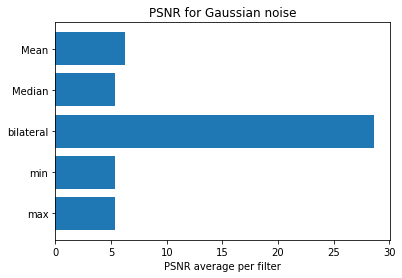

In [143]:
g_mse_means, g_psr_means = gaussn_avg()
plot_performance(g_psr_means, "PSNR average per filter", "PSNR for Gaussian noise")

Plotting MSE for Gaussian Noise

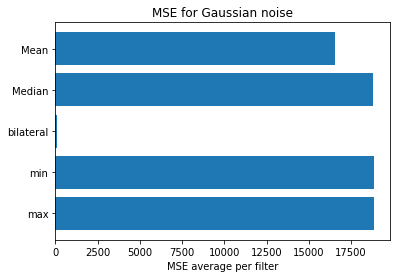

In [145]:
plot_performance(g_mse_means, "MSE average per filter", "MSE for Gaussian noise")

Plotting PSNR for Impulse Noise

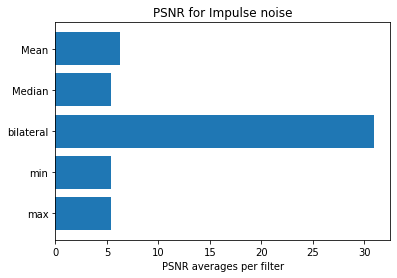

In [137]:
mse_means, psr_means = impulse_avg()
#plot_performance(mse_means)
plot_performance(psr_means, "PSNR averages per filter", "PSNR for Impulse noise")


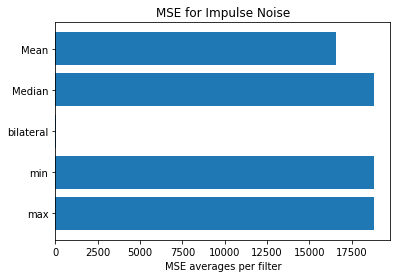

In [138]:
plot_performance(mse_means, "MSE averages per filter", "MSE for Impulse Noise")

Example picture with filters

Mean with Gaussian

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  """
/usr/local/lib/python3.7/dist-packages/skimage/measure/_structural_similarity.py:17: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  **kwargs)


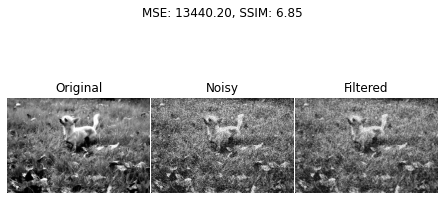

(13440.200163061205, 0.006099878953323813, 6.846746242136721)

In [146]:
mean_g = mean_filter(img_gauss_noise)
compare(img_original, img_gauss_noise, mean_g)

Median with Gaussian

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  """
/usr/local/lib/python3.7/dist-packages/skimage/measure/_structural_similarity.py:17: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  **kwargs)


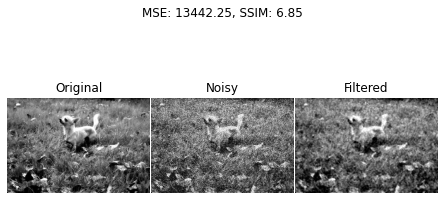

(13442.248, 0.005776636161577135, 6.846084557877398)

In [147]:
median_g = median_filter(img_gauss_noise)
compare(img_original, img_gauss_noise, median_g)

Bilateral with Gaussian

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  """


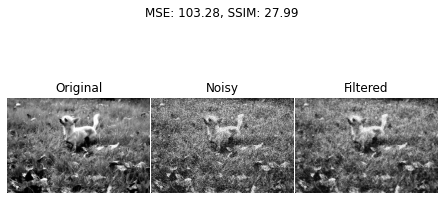

(103.2787027027027, 0.3310196667446849, 27.990695868050935)

In [148]:
bilateral_g = bilateral(img_gauss_noise)
compare(img_original, img_gauss_noise, bilateral_g)

Min with Gaussian

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  """
/usr/local/lib/python3.7/dist-packages/skimage/measure/_structural_similarity.py:17: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  **kwargs)


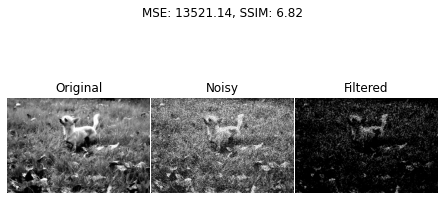

(13521.138, 0.004826645571467373, 6.8206712532674105)

In [149]:
min_g = min(img_gauss_noise)
compare(img_original, img_gauss_noise, min_g)

Max with Gaussian

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  """
/usr/local/lib/python3.7/dist-packages/skimage/measure/_structural_similarity.py:17: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  **kwargs)


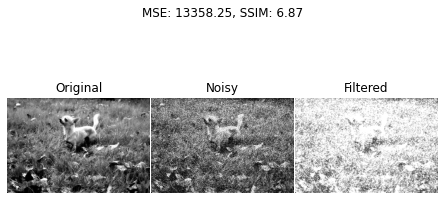

(13358.252, 0.008059242840988684, 6.873307303318013)

In [150]:
max_g = max(img_gauss_noise)
compare(img_original, img_gauss_noise, max_g)

Mean with Impulse

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  """
/usr/local/lib/python3.7/dist-packages/skimage/measure/_structural_similarity.py:17: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  **kwargs)


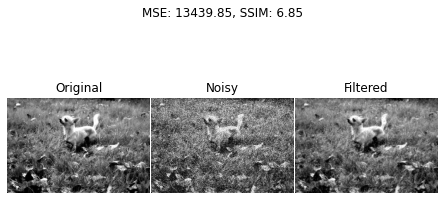

(13439.84955221544, 0.005815081501659881, 6.846859536834636)

In [151]:
mean_i = mean_filter(img_saltpepper_noise)
compare(img_original, img_gauss_noise, mean_i)

Median with Impulse

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  """
/usr/local/lib/python3.7/dist-packages/skimage/measure/_structural_similarity.py:17: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  **kwargs)


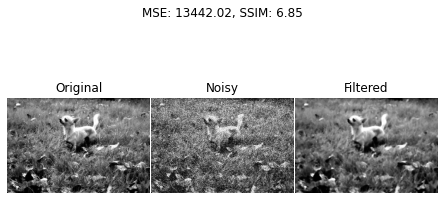

(13442.016, 0.005690514228623272, 6.846159649789173)

In [152]:
median_i = median_filter(img_saltpepper_noise)
compare(img_original, img_gauss_noise, median_i)

Bilateral with Impulse

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  """


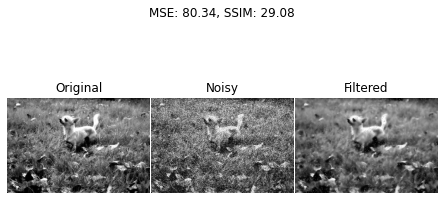

(80.34335735735736, 0.537165280694431, 29.081303849620667)

In [153]:
bilateral_i = bilateral(img_saltpepper_noise)
compare(img_original, img_gauss_noise, bilateral_i)

Min with Impulse

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  """
/usr/local/lib/python3.7/dist-packages/skimage/measure/_structural_similarity.py:17: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  **kwargs)


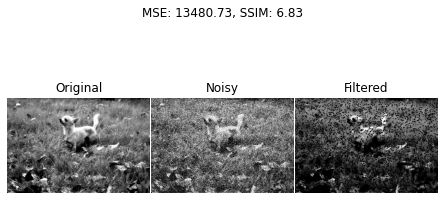

(13480.727, 0.005299420756659969, 6.83367061132922)

In [154]:
min_i = min(img_saltpepper_noise)
compare(img_original, img_gauss_noise, min_i)

Max with Impulse

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  """
/usr/local/lib/python3.7/dist-packages/skimage/measure/_structural_similarity.py:17: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  **kwargs)


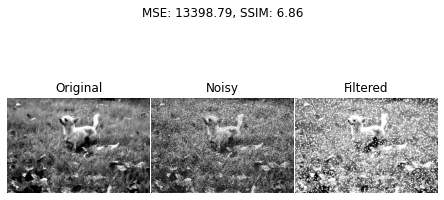

(13398.785, 0.006856613283096035, 6.860149374176211)

In [155]:
max_i = max(img_saltpepper_noise)
compare(img_original, img_gauss_noise, max_i)